# Predictions of the used cars' prices

In [1]:
from copy import deepcopy
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, \
GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression, OrthogonalMatchingPursuit, \
PassiveAggressiveRegressor, SGDRegressor
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tempfile import mkdtemp
import warnings

from helper_functions import get_common_brands, get_common_models, get_scores, display_scores
from transforming_classes import UnitsRemovingTransformer, BrandModelEncoder, MappingTransformer, ReplaceOutliers, ReplaceZeros

In [2]:
warnings.filterwarnings('ignore')

## Loading data

In [3]:
df = pd.read_csv("cars_train.csv", index_col=0)
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Data transformations

### New_Price

In [4]:
new_price_pipeline = Pipeline(
    
    steps = [
        ('drop_column', ColumnTransformer(remainder='passthrough', transformers=[('drop_columns', 'drop', ['New_Price'])]))
    ]
         
    )

### Mileage & Engine & Power

In [5]:
m_e_p_pipeline_with_outliers_replaced = Pipeline(
    
    steps = [
        ('remove_units', UnitsRemovingTransformer()),
        ('replace_zeros', ReplaceZeros()),
        ('replace_outliers', ReplaceOutliers()),
        ('scale_data', StandardScaler())
    ]

)

m_e_p_pipeline_with_outliers = Pipeline(
    
    steps = [
        ('remove_units', UnitsRemovingTransformer()),
        ('replace_zeros', ReplaceZeros()),
        ('scale_data', StandardScaler())
    ]

)

### Year & Seats

In [6]:
y_s_pipeline_with_outliers_replaced = Pipeline(
    
    steps = [
        ('replace_outliers', ReplaceOutliers()),
        ('scale_data', StandardScaler())
    ]

)

y_s_pipeline_with_outliers = Pipeline(
    
    steps = [
        ('scale_data', StandardScaler())
    ]

)

### Name

In [7]:
common_brands = get_common_brands()
common_brands_models = get_common_models()

name_pipeline = Pipeline(
    
    steps = [
        ('create_brand_model_columns', BrandModelEncoder(common_brands, common_brands_models))
    ]

)

### Fuel_Type

In [8]:
fuel_type_pipeline = Pipeline(
    steps = [
        ('create_dummies', OneHotEncoder(max_categories=2, handle_unknown='ignore', sparse=False))
    ]
)

### Owner_Type

In [9]:
owners = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 3}
owner_type_pipeline = Pipeline(
    steps = [
        ('map_owners', MappingTransformer(owners)),
        ('scale_data', StandardScaler())
    ]
)

### Transmission

In [10]:
transmission_pipeline = Pipeline(
    steps = [
        ('create_dummies', OneHotEncoder(max_categories=1, handle_unknown='ignore', sparse=False))
    ]
)

### Location

In [11]:
location_pipeline = Pipeline(
    steps = [
        ('create_dummies', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

### Price

In [12]:
y_transformer = QuantileTransformer(output_distribution='normal')
y_train_transformed = y_transformer.fit_transform(pd.DataFrame(y_train))

### Pipelines combined

In [13]:
preprocessing_outliers_replaced = ColumnTransformer(remainder='passthrough',
                                                    transformers=[
                                                        ('new_price_pipeline', new_price_pipeline, ['New_Price']),
                                                        ('m_e_p_pipeline_with_outliers_replaced', 
                                                         m_e_p_pipeline_with_outliers_replaced, ['Mileage', 'Engine', 'Power']),
                                                        ('y_s_pipeline_with_outliers_replaced', 
                                                         y_s_pipeline_with_outliers_replaced, ['Year', 'Seats']),
                                                        ('name_pipeline', name_pipeline, ['Name']),
                                                        ('fuel_type_pipeline', fuel_type_pipeline, ['Fuel_Type']),
                                                        ('owner_type_pipeline', owner_type_pipeline, ['Owner_Type']),
                                                        ('transmission_pipeline', transmission_pipeline, ['Transmission']),
                                                        ('location_pipeline', location_pipeline, ['Location'])
                                                    ])

preprocessing_with_outliers = ColumnTransformer(remainder='passthrough',
                                                    transformers=[
                                                        ('new_price_pipeline', new_price_pipeline, ['New_Price']),
                                                        ('m_e_p_pipeline_with_outliers', 
                                                         m_e_p_pipeline_with_outliers, ['Mileage', 'Engine', 'Power']),
                                                        ('y_s_pipeline_with_outliers', 
                                                         y_s_pipeline_with_outliers, ['Year', 'Seats']),
                                                        ('name_pipeline', name_pipeline, ['Name']),
                                                        ('fuel_type_pipeline', fuel_type_pipeline, ['Fuel_Type']),
                                                        ('owner_type_pipeline', owner_type_pipeline, ['Owner_Type']),
                                                        ('transmission_pipeline', transmission_pipeline, ['Transmission']),
                                                        ('location_pipeline', location_pipeline, ['Location'])
                                                    ])

## Models

### Base grid search parameters

In [14]:
grid_params = [
    {'model': [LinearRegression()],
     'impute__n_neighbors': [1, 3, 5]
    },
    {'model': [DecisionTreeRegressor(random_state=42)],
     'model__criterion': ['squared_error', 'absolute_error'],
     'model__splitter': ['best', 'random'],
     'model__min_samples_split': [2, 3, 5],
     'impute__n_neighbors': [1, 3, 5],
    },
    {'model': [ElasticNet()],
     'model__alpha': [.1, .5, .9],
     'model__l1_ratio': [0, .1, .5, .9, 1],
     'model__max_iter': [1000, 10000],
     'impute__n_neighbors': [1, 3, 5],
    },
    {'model': [OrthogonalMatchingPursuit()],
     'impute__n_neighbors': [1, 3, 5],
    },
    {'model': [BayesianRidge()],
     'model__alpha_1': [1e-8, 1e-6],
     'model__alpha_2': [1e-8, 1e-6],
     'model__lambda_1': [1e-8, 1e-6],
     'model__lambda_2': [1e-8, 1e-6],
     'impute__n_neighbors': [1, 3, 5],
    },
    {'model': [SGDRegressor()],
     'model__loss': ['squared_error', 'huber', 'squared_epsilon_insensitive'],
     'model__alpha': [1e-5, 1e-4, 1e-3],
     'model__max_iter': [100, 1000, 10000],
     'impute__n_neighbors': [1, 3, 5],
    },
    {'model': [PassiveAggressiveRegressor()],
     'model__C': [.5, 1, 2],
     'model__max_iter': [100, 1000, 10000],
     'model__tol': [1e-4, 1e-3, 1e-2],
     'impute__n_neighbors': [1, 3, 5],
    }
]

### Feature decomposition & outliers replacement

In [15]:
cachedir = mkdtemp()
dec_repl_pipe = Pipeline(steps=[
    ('preprocessing', preprocessing_outliers_replaced),
    ('impute', KNNImputer()),
    ('feature_decoposition', IncrementalPCA(n_components=7, batch_size=200)),
    ('model', DecisionTreeRegressor())
    ]
    , memory=cachedir
    )

In [16]:
dec_params = deepcopy(grid_params)
for dict_index, _ in enumerate(grid_params):
    dec_params[dict_index]['feature_decoposition__n_components'] = [5, 7, 9]

In [17]:
dec_repl_grid = GridSearchCV(dec_repl_pipe, dec_params, n_jobs=-1)

In [18]:
dec_repl_grid.fit(X_train, y_train)
dec_repl_prediction = dec_repl_grid.predict(X_test)

In [19]:
dec_repl_scores = get_scores(y_test, dec_repl_prediction)
display_scores(dec_repl_grid.best_params_['model'], dec_repl_scores)

Results for model DecisionTreeRegressor(criterion='absolute_error', min_samples_split=5,
                      random_state=42, splitter='random')
Mean absolute error: 2.67
Median absolute error: 1.03
Mean absolute percentage error: 0.33
Root mean squared error: 6.04
Max error: 90.98
R2 score: 0.7


In [20]:
dec_repl_grid.best_params_['feature_decoposition__n_components']

7

In [21]:
dec_repl_grid.best_params_['impute__n_neighbors']

3

Since the best number of neighbors in KNNImputer() is 3, I remove 'impute__n_neighbors' from grid_params, and I will be using KNNImputer(n_neighbors=3) further on.

In [22]:
for dict_index, _ in enumerate(grid_params[:]):
    del grid_params[dict_index]['impute__n_neighbors']

### Outliers replacement

In [23]:
cachedir = mkdtemp()
repl_pipe = Pipeline(steps=[
    ('preprocessing', preprocessing_outliers_replaced),
    ('impute', KNNImputer(n_neighbors=3)),
    ('model', DecisionTreeRegressor())
    ]
    , memory=cachedir
    )

In [24]:
repl_grid = GridSearchCV(repl_pipe, grid_params, n_jobs=-1)
repl_grid.fit(X_train, y_train)
repl_prediction = repl_grid.predict(X_test)
repl_scores = get_scores(y_test, repl_prediction)
display_scores(repl_grid.best_params_['model'], repl_scores)

Results for model DecisionTreeRegressor(criterion='absolute_error', min_samples_split=3,
                      random_state=42, splitter='random')
Mean absolute error: 2.06
Median absolute error: 0.7
Mean absolute percentage error: 0.23
Root mean squared error: 5.22
Max error: 90.5
R2 score: 0.78


### No outliers replacements & no feature decomposition

In [25]:
cachedir = mkdtemp()
simple_pipe = Pipeline(steps=[
    ('preprocessing', preprocessing_with_outliers),
    ('impute', KNNImputer(n_neighbors=3)),
    ('model', DecisionTreeRegressor())
    ]
    , memory=cachedir
    )

In [26]:
simple_grid = GridSearchCV(simple_pipe, grid_params, n_jobs=-1)
simple_grid.fit(X_train, y_train)
simple_prediction = simple_grid.predict(X_test)
simple_scores = get_scores(y_test, simple_prediction)
display_scores(simple_grid.best_params_['model'], simple_scores)

Results for model DecisionTreeRegressor(min_samples_split=3, random_state=42)
Mean absolute error: 2.04
Median absolute error: 0.7
Mean absolute percentage error: 0.24
Root mean squared error: 5.26
Max error: 81.94
R2 score: 0.78


Here's what the decision tree looks like.

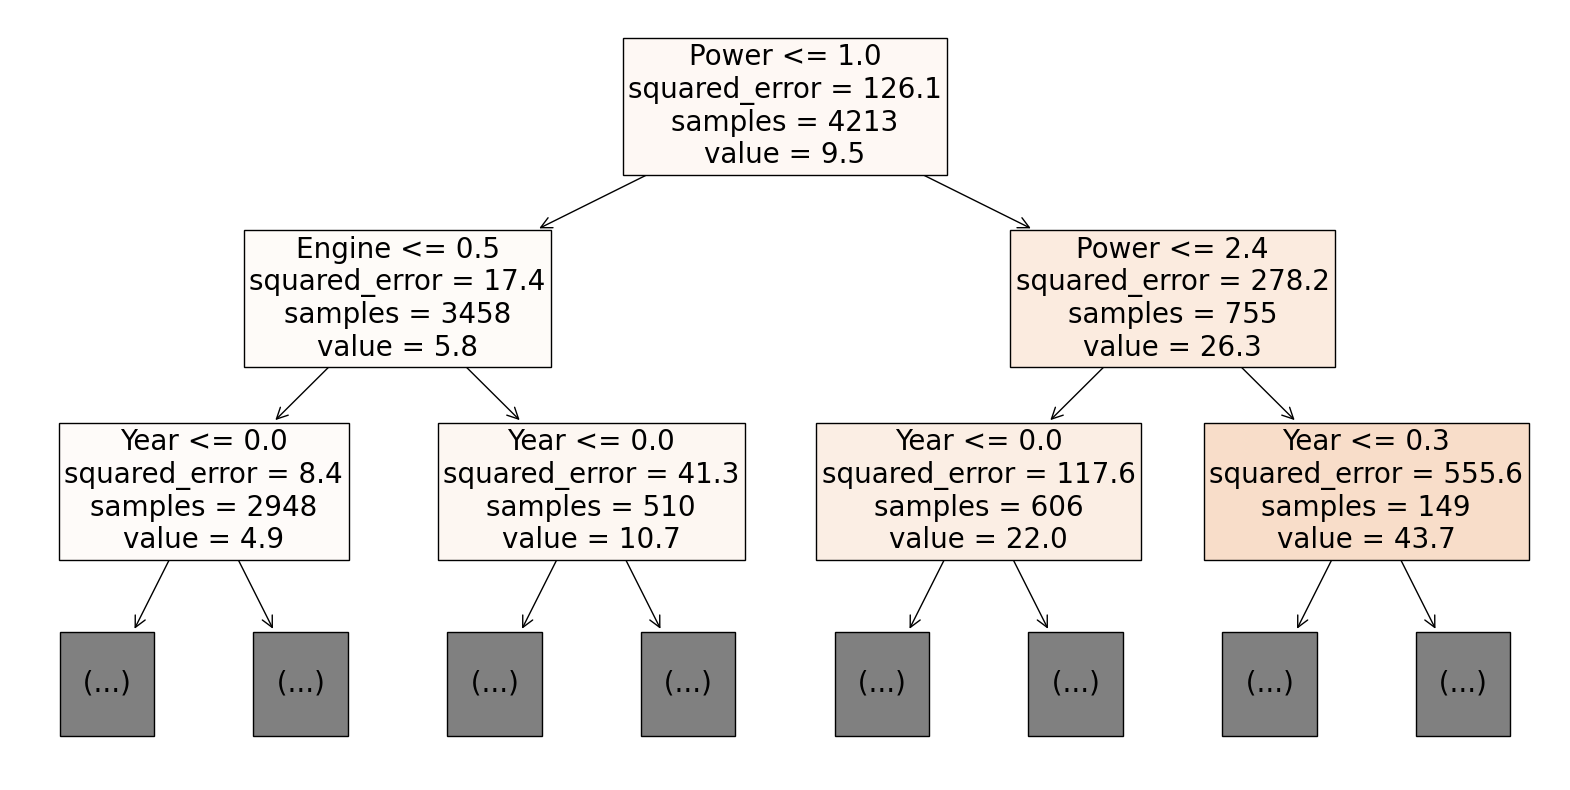

In [27]:
features_short_names = [x.split('__')[-1] for x in simple_grid.best_estimator_.steps[0][1].get_feature_names_out()]
fig = plt.figure(figsize=(20, 10))
plot_tree(simple_grid.best_estimator_['model'], 
          max_depth=2,
          impurity=True,
          feature_names=features_short_names,   # changed this argument to make it work properly
          precision=1,
          filled=True,
          fontsize=20,
 );

### Ensemble methods

In [28]:
ensemble_grid_params = [
    {'model': [AdaBoostRegressor(random_state=42)],
     'model__n_estimators': [100, 200, 300],
     'model__loss': ['linear', 'square', 'exponential']
    },
    {'model': [BaggingRegressor(random_state=42)],
     'model__n_estimators': [10, 20, 30],
     'model__estimator': [DecisionTreeRegressor, SVR()]
    },
    {'model': [ExtraTreesRegressor(random_state=42)],
     'model__n_estimators': [50, 100, 300, 500]
    },
    {'model': [GradientBoostingRegressor(random_state=42)],
     'model__n_estimators': [50, 100, 300, 500],
     'model__loss': ['squared_error', 'huber', 'quantile']
    },
    {'model': [RandomForestRegressor(random_state=42)],
     'model__n_estimators': [50, 100, 300, 500],
     'model__criterion': ['squared_error', 'friedman_mse', 'poisson']
    },
    {'model': [VotingRegressor([('lr', LinearRegression()), 
                                ('rf', RandomForestRegressor(n_estimators=10, random_state=42)), 
                                ('r3', KNeighborsRegressor())
                               ])]
    },
]

In [29]:
cachedir = mkdtemp()
ensemble_pipe = Pipeline(steps=[
    ('preprocessing', preprocessing_with_outliers),
    ('impute', KNNImputer(n_neighbors=3)),
    ('model', None)
    ]
    , memory=cachedir
    )
ensemble_grid = GridSearchCV(ensemble_pipe, ensemble_grid_params, n_jobs=-1, scoring='r2')
ensemble_grid.fit(X_train, y_train)
ensemble_prediction = ensemble_grid.predict(X_test)
ensemble_scores = get_scores(y_test, ensemble_prediction)
display_scores(ensemble_grid.best_params_['model'], ensemble_scores)

Results for model GradientBoostingRegressor(loss='huber', n_estimators=500, random_state=42)
Mean absolute error: 1.46
Median absolute error: 0.54
Mean absolute percentage error: 0.17
Root mean squared error: 3.59
Max error: 58.67
R2 score: 0.9


Ensemble methods give similar results to a simple DecisionTreeRegressor. Now I'll check if target transformations improve the result.

### Outliers replacement & target transformation

In [30]:
repl_tar_grid = GridSearchCV(repl_pipe, grid_params, n_jobs=-1)
repl_tar_grid.fit(X_train, y_train_transformed)
repl_tar_prediction = repl_tar_grid.predict(X_test)
repl_tar_prediction = y_transformer.inverse_transform(repl_tar_prediction.reshape(-1, 1))
repl_tar_scores = get_scores(y_test, repl_tar_prediction)
display_scores(repl_tar_grid.best_params_['model'], repl_tar_scores)

Results for model BayesianRidge(alpha_1=1e-08, lambda_2=1e-08)
Mean absolute error: 1.72
Median absolute error: 0.6
Mean absolute percentage error: 0.19
Root mean squared error: 4.23
Max error: 64.56
R2 score: 0.85


### Target transformation & no outliers replacement

In [31]:
tar_grid = GridSearchCV(simple_pipe, grid_params, n_jobs=-1)
tar_grid.fit(X_train, y_train_transformed)
tar_prediction = tar_grid.predict(X_test)
tar_prediction = y_transformer.inverse_transform(tar_prediction.reshape(-1, 1))
tar_scores = get_scores(y_test, tar_prediction)
display_scores(tar_grid.best_params_['model'], tar_scores)

Results for model BayesianRidge(alpha_1=1e-08, lambda_2=1e-08)
Mean absolute error: 1.68
Median absolute error: 0.6
Mean absolute percentage error: 0.18
Root mean squared error: 4.14
Max error: 64.55
R2 score: 0.86


### NaNs removal & target transformation & no outliers replacement

In [32]:
# retrieving only data without NaNs.
X_train_no_na = X_train.dropna(axis=0, subset=X_train.drop('New_Price', axis=1).columns)
y_train_no_na = y_train[X_train_no_na.index]
X_test_no_na = X_test.dropna(axis=0, subset=X_test.drop('New_Price', axis=1).columns)
y_test_no_na = y_test[X_test_no_na.index]

In [33]:
# Replacing NaNs with KNNImputer() is still necessary since new Nans appear during transformations.
y_train_no_na_transformed = y_transformer.fit_transform(pd.DataFrame(y_train_no_na))
rem_tar_grid = GridSearchCV(simple_pipe, grid_params, n_jobs=-1)
rem_tar_grid.fit(X_train_no_na, y_train_no_na_transformed)
rem_tar_prediction = rem_tar_grid.predict(X_test_no_na)
rem_tar_prediction = y_transformer.inverse_transform(rem_tar_prediction.reshape(-1, 1))
rem_tar_scores = get_scores(y_test_no_na, rem_tar_prediction)
display_scores(rem_tar_grid.best_params_['model'], rem_tar_scores)

Results for model BayesianRidge(alpha_1=1e-08, lambda_2=1e-08)
Mean absolute error: 1.69
Median absolute error: 0.59
Mean absolute percentage error: 0.18
Root mean squared error: 4.21
Max error: 64.55
R2 score: 0.86


## Ensemble methods & target transformation

In [34]:
ensemble_tar_grid = GridSearchCV(ensemble_pipe, ensemble_grid_params, n_jobs=-1, scoring='r2')
ensemble_tar_grid.fit(X_train, y_train_transformed)
ensemble_tar_prediction = ensemble_tar_grid.predict(X_test)
ensemble_tar_prediction = y_transformer.inverse_transform(ensemble_tar_prediction.reshape(-1, 1))
ensemble_tar_scores = get_scores(y_test, ensemble_tar_prediction)
display_scores(ensemble_tar_grid.best_params_['model'], ensemble_tar_scores)

Results for model GradientBoostingRegressor(loss='huber', n_estimators=500, random_state=42)
Mean absolute error: 1.37
Median absolute error: 0.5
Mean absolute percentage error: 0.15
Root mean squared error: 3.38
Max error: 54.79
R2 score: 0.91


## Models' comparison

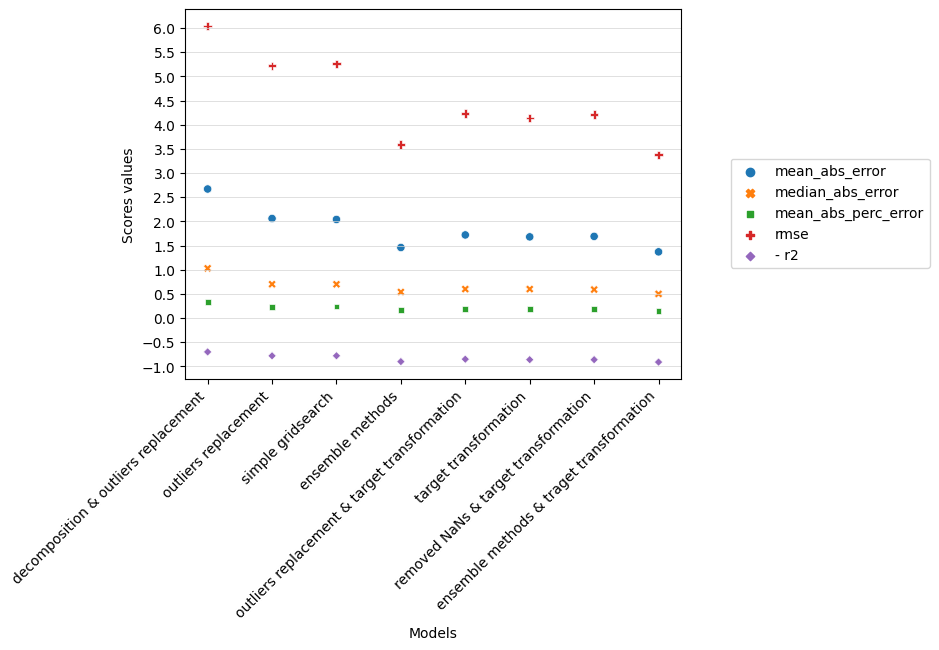

In [35]:
scores_list = [dec_repl_scores, repl_scores, simple_scores, ensemble_scores, repl_tar_scores, tar_scores, rem_tar_scores, 
               ensemble_tar_scores]
index = ['decomposition & outliers replacement', 'outliers replacement', 'simple gridsearch', 'ensemble methods', 
         'outliers replacement & target transformation', 'target transformation', 'removed NaNs & target transformation', 
        'ensemble methods & traget transformation']
scores_data = pd.DataFrame(scores_list, index=index)
scores_data['- r2'] =  - scores_data['r2']
sns.scatterplot(scores_data.drop(['max_error', 'r2'], axis=1))
plt.legend(loc=(1.1, 0.3))
plt.xlabel('Models')
plt.ylabel('Scores values')
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(-1, 6.2, 0.5))
plt.grid(axis='y', linewidth='0.5', color='lightgrey')

The best model (with the lowest error values and highest R2 score) seem to be the one retrieved using ensemble methods and target transformation. To be sure the model predicts well, I'll first draw a few graphs.

## Comparison of actual and predicted values

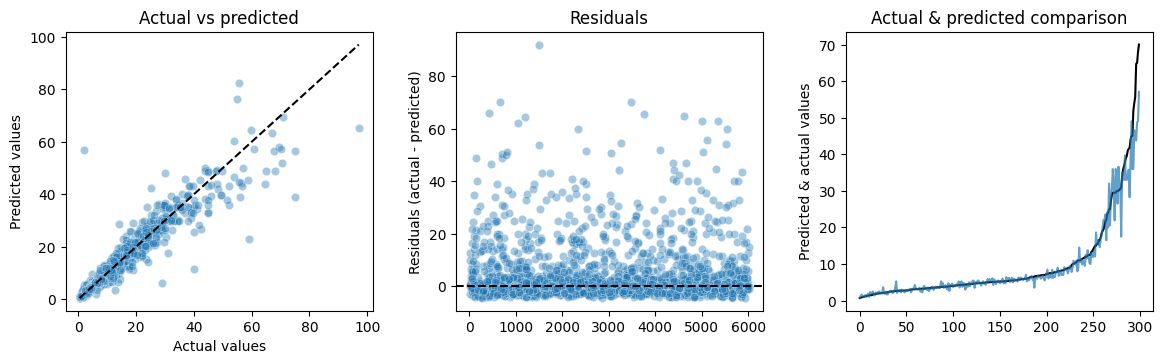

In [36]:
prediction_vs_true_df = pd.DataFrame({'y_true': y_test, 'y_predicted': [val[0] for val in ensemble_tar_prediction]})
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=prediction_vs_true_df, x='y_true', y='y_predicted', alpha=0.4)
p1 = max(max(prediction_vs_true_df['y_predicted']), max(prediction_vs_true_df['y_true']))
p2 = min(min(prediction_vs_true_df['y_predicted']), min(prediction_vs_true_df['y_true']))
plt.plot([p2, p1], [p2, p1], color='black', linestyle='dashed')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs predicted')

plt.subplot(1, 3, 2)
sns.scatterplot(y_test - ensemble_tar_prediction[0], alpha=0.4)
plt.axhline(0, color='black', linestyle='dashed')
plt.ylabel('Residuals (actual - predicted)')
plt.title('Residuals')

sample_size = 300
index_sample = random.sample(list(prediction_vs_true_df['y_true'].index), sample_size)
indexes = prediction_vs_true_df['y_true'][index_sample].sort_values().index

plt.subplot(1, 3, 3)
sns.lineplot(x=np.arange(0, sample_size, 1), y=prediction_vs_true_df['y_true'][indexes], color='black')
sns.lineplot(x=np.arange(0, sample_size, 1), y=prediction_vs_true_df['y_predicted'][indexes], color='#1f77b4', alpha=0.7)
plt.ylabel('Predicted & actual values')
plt.title('Actual & predicted comparison')

fig.tight_layout(pad=2)

The model seems to be appropriate:
- most of the points are close to regressed diagonal line,
- residuals are randomly scattered around y = 0,
- actual and predicted values are usually close to each other.

## Saving the chosen model

In [37]:
chosen_model = ensemble_tar_grid.best_estimator_
chosen_model

Pipeline(memory='C:\\Users\\katar\\AppData\\Local\\Temp\\tmpuqo1g5mz',
         steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('new_price_pipeline',
                                                  Pipeline(steps=[('drop_column',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('drop_columns',
                                                                                                    'drop',
                                                                                                    ['New_Price'])]))]),
                                                  ['New_Price']),
                                                 ('m_e_p_pipeline_with_outliers',
                                                  P...
                                                  Pipeline(steps=[('create_dummies',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 max_categories=1,
                                                                                 sparse=False))]),
                                                  ['Transmission']),
                                                 ('location_pipeline',
                                                  Pipeline(steps=[('create_dummies',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Location'])])),
                ('impute', KNNImputer(n_neighbors=3)),
                ('model',
                 GradientBoostingRegressor(loss='huber', n_estimators=500,
                                           random_state=42))])

In [38]:
dump(chosen_model, "cars_chosen_model.joblib")

['cars_chosen_model.joblib']